In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import os, pickle, cv2
import seaborn as sns; sns.set()
from numpy import asarray
import PIL
from PIL import Image
### sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

### tensorflow libraries
import tensorflow
from keras import applications

from tensorflow.keras.applications.vgg16 import VGG16 
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image    



from tensorflow.keras.layers import BatchNormalization
from keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Activation, Flatten, Dropout, Dense
# import tensorflow
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adagrad, Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files

!cp /content/drive/MyDrive/foodtask/gradcam.py /content/ 
!cp /content/drive/MyDrive/foodtask/getalldata.py /content/ 

from gradcam import *
from getalldata import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import shutil
try:
  shutil.rmtree("/content/food")
except:
  pass

try:
  shutil.rmtree("/content/food_pre")
except:
  pass

os.mkdir("food")

In [ ]:
# !unzip "/content/drive/MyDrive/foodtask/Train.zip" -d /content/food/
# !unzip "/content/drive/MyDrive/foodtask/Valid.zip" -d /content/food/
# !unzip "/content/drive/MyDrive/foodtask/Test.zip" -d /content/food/Test/

To save time, data were processed in a first time (refer to **getalldata.py** script) and downloaded for ulterior uses.

In [ ]:
data = {}
data_inet = {}
w = 80
h = 60
metadata = {"Train/":{0:0, 1:0}, "Valid/":{0:0, 1:0}}
right = True

# data
try:
  a_file = open("/content/drive/MyDrive/foodtask/data.pkl", "rb")
  data = pickle.load(a_file)
except:
  right = False
# data_inet
try:
  a_file = open("/content/drive/MyDrive/foodtask/data_inet.pkl", "rb")
  data_inet = pickle.load(a_file)
except:
  right = False
# data_stack
try:
  a_file = open("/content/drive/MyDrive/foodtask/data_stack.pkl", "rb")
  data_stack = pickle.load(a_file)
except:
  right = False

if not right:
  data, data_inet, data_stack = getall()

In [ ]:
# get y_valid and y_train
y = True
try:
  a_file = open("/content/drive/MyDrive/foodtask/y_train.pkl", "rb")
  y_train = pickle.load(a_file)
except:
  y = False
try:
  a_file = open("/content/drive/MyDrive/foodtask/y_valid.pkl", "rb")
  y_valid = pickle.load(a_file)
except:
  y = False

if not y:
  y_train =  np.concatenate( (np.zeros((metadata["Train/"][0],1)), np.ones((metadata["Train/"][1],1))) )
  y_valid =  np.concatenate( (np.zeros((metadata["Valid/"][0],1)), np.ones((metadata["Valid/"][1],1))) )
y_train.shape, y_valid.shape

((13113, 1), (3279, 1))

In [ ]:
data_inet["Train/"] = np.array(data_inet["Train/"])
data_inet["Train/"] = preprocess_input(data_inet["Train/"])


In [ ]:
data_inet["Valid/"] = np.array(data_inet["Valid/"])
data_inet["Valid/"] = preprocess_input(data_inet["Valid/"])

In [ ]:
from keras.utils.generic_utils import class_and_config_for_serialized_keras_object
import random
test_dir = "/content/food/Test/evaluation"
val_dir = "/content/food/Valid/"

def make_prediction(classifier, img_path, conv, image_re):
  classes_x,predict = None, None
  # Extract features
  if conv:

    image = cv2.imread(img_path)
    img = cv2.resize(image,(w,h))
    img_tensor = preprocess_input(np.copy(img))

    if img_tensor.shape[-1] == 3:
      features = conv.predict(img_tensor.reshape(1,h, w, 3))
    else:
      features = conv.predict(img_tensor.reshape(1,h, w, 1))

    if "SGDC" in str(type(classifier)):
      features = features.reshape((-1,1024))
  # Make prediction
    try:
      prediction = classifier.predict(features)
    except:
      prediction = classifier.predict(features.reshape(1, 60*80*128))

    img_tensor /=255.

  else:
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img,(80,60))
    gs_image = img.reshape((1,h,w,1))
    img_tensor = asarray(gs_image) # /255.0

    try:
      prediction = classifier.predict(img_tensor)
      classes_x=np.argmax(prediction,axis=-1)
    except:
      prediction = classifier.predict(img_tensor.reshape(1,60*80*128))
      classes_x=np.argmax(prediction,axis=-1)
      predict = classifier.predict(img_tensor, steps=None, callbacks=None, max_queue_size=10, workers=1,use_multiprocessing=False, verbose=0
    )
  return prediction,classes_x,predict, img_tensor

In [ ]:
# # UNZIP AND GET MODELs
!unzip "/content/drive/MyDrive/foodtask/DNN1st.zip" -d /content/model

Archive:  /content/drive/MyDrive/foodtask/DNN1st.zip
   creating: /content/model/content/food/firsttry/
   creating: /content/model/content/food/firsttry/variables/
  inflating: /content/model/content/food/firsttry/variables/variables.data-00000-of-00001  
  inflating: /content/model/content/food/firsttry/variables/variables.index  
   creating: /content/model/content/food/firsttry/assets/
  inflating: /content/model/content/food/firsttry/keras_metadata.pb  
  inflating: /content/model/content/food/firsttry/saved_model.pb  


In [ ]:
model = tensorflow.keras.models.load_model("/content/model/content/food/firsttry")
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_43 (Dense)            (None, 32)                153632    
                                                                 
 dense_44 (Dense)            (None, 30)                990       
                                                                 
 dense_45 (Dense)            (None, 64)                1984      
                                                                 
 dense_46 (Dense)            (None, 64)                4160      
                                                                 
 dense_47 (Dense)            (None, 64)                4160      
                                                                 
 dense_48 (Dense)            (None, 1)                 65        
                                                                 
Total params: 164,991
Trainable params: 164,991
Non-tr

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adagrad, Adam
from keras.optimizers import gradient_descent_v2 as SGD

"""
Getting xtrain and ytrain from data_stack
"""

xtrain, xvalid = data_stack["Train/"][:,:-1], data_stack["Valid/"][:,:-1] 
ytrain, yvalid = data_stack["Train/"][:,-1], data_stack["Valid/"][:,-1]

def getmodelDNN(h,w):

  model = Sequential()

  model.add(Dense(32, input_dim=h*w, activation='relu'))
  model.add(Dense(30, activation='relu'))
  model.add(Dense(64, activation='relu'))

  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # compile the keras model

  opt = Adam()
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

  return model


def trainmodelDNN(model, data):
  xtrain, ytrain = data[0], data[1]
  xvalid, yvalid = data[2], data[3]
# fit 
  rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=50)

  history = model.fit(xtrain, ytrain,validation_split = 0.2, epochs=500, batch_size=256, callbacks=[rlrop])
  model.save('/content/food/second')
  # evaluate 
  _, accuracy = model.evaluate(xtrain, ytrain)

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  print('Accuracy: %.2f' % (accuracy*100))

  _, acc = model.evaluate(xvalid,yvalid)
  print('Accuracy: %.2f' % (acc*100))
  return history, accuracy

# Data = [xtrain,ytrain, xvalid, yvalid]
# model = getmodelDNN(h,w)
# hist, acc = trainmodelDNN(model, Data)

In [ ]:
bag_metadata = {}

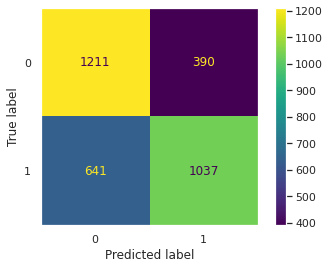

              precision    recall  f1-score   support

         0.0       0.65      0.76      0.70      1601
         1.0       0.73      0.62      0.67      1678

    accuracy                           0.69      3279
   macro avg       0.69      0.69      0.68      3279
weighted avg       0.69      0.69      0.68      3279



In [ ]:
xvalid,yvalid = data_stack["Valid/"][:,:-1],data_stack["Valid/"][:,-1] 
# _, acc = model.evaluate(xvalid,yvalid)
y_pred = model.predict(xvalid)

y_pred = np.where(y_pred < 0.5, 0, 1)
cm = confusion_matrix(yvalid, y_pred)
dispDNN = ConfusionMatrixDisplay(confusion_matrix=cm,
                         display_labels=[0,1])
dispDNN.plot()
plt.grid(False)
plt.show()
cl_reportDNN = classification_report(yvalid,y_pred) 
print(cl_reportDNN)

In [ ]:
bag_metadata["DNN"] = {"model": model, "conv": None, "metrics":[cm,cl_reportDNN], "data":(data_stack["Valid/"],y_valid)} 

For this model, we'll use the data in the 3 channels format (60, 80, 3) as*vgg16* was trained with 3 channels

In [ ]:
# !unzip "/content/drive/MyDrive/foodtask/trained_vgg16.zip" -d /content/model
# model = tensorflow.keras.models.load_model("/content/trained_vgg16 (1).h5")
model = tensorflow.keras.models.load_model("/content/drive/MyDrive/foodtask/vgg16/trained_vgg16.h5") 

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 1024)              0         
                                                                 
 dense_10 (Dense)            (None, 256)               262400    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 257       
                                                                 
Total params: 262,657
Trainable params: 262,657
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# PRE TRAINED MODEL VGG16
conv = tensorflow.keras.applications.VGG16(include_top=False,weights='imagenet')

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
conv.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

Extract the features for both TRAINING and VALIDATION

In [ ]:
features_dataTrain = np.load('/content/drive/MyDrive/foodtask/vgg16/featuresTrain_vgg16SVM.npy')
features_dataVal = np.load('/content/drive/MyDrive/foodtask/vgg16/featuresValid_vgg16SVM.npy')
features_dataTrain.shape, features_dataVal.shape

((13113, 1024), (3279, 1024))

In [ ]:
# Reference: https://github.com/SaideshwarKotha/Food-Image-Classifier/blob/master/FoodImage_Classification.ipynb

if len(features_dataTrain) == 0:
  features_dataTrain, features_dataVal = features_vgg(data_inet)

In [ ]:
n_cl0tr, n_cl1tr = 6404, 6709
n_cl0val, n_cl1val = 1601, 1678

In [ ]:
y_trainvgg =  np.concatenate( (np.ones((n_cl1tr,1)),np.zeros((n_cl0tr,1))) )
y_validvgg =  np.concatenate( (np.ones((n_cl1val,1)),np.zeros((n_cl0val,1))) )

In [ ]:
"""
Again, the validation set comes from the TRAIN folder provided, so to have the entire
TEST folder for testing
"""

features_dataTrain = features_dataTrain.reshape((-1,1,2,512))
features_dataVal = features_dataVal.reshape((-1,1,2,512))

xtrain, xvalid, ytrain, yvalid = train_test_split(features_dataTrain, y_trainvgg, stratify=y_trainvgg, test_size=0.2)

In [ ]:
print('Number of data points in train data:', xtrain.shape[0])
print('Number of data points in cross validation data:', xvalid.shape[0])
# print('Number of data points in test data:', X_test.shape[0])

Number of data points in train data: 10490
Number of data points in cross validation data: 2623


# Train the fully connecte layers

In [ ]:
!unzip "/content/drive/MyDrive/foodtask/vgg16/vgg16.zip" -d /content/vgg16final
model = tensorflow.keras.models.load_model("/content/vgg16final/vgg16")

Archive:  /content/drive/MyDrive/foodtask/vgg16/vgg16.zip
   creating: /content/vgg16final/vgg16/
   creating: /content/vgg16final/vgg16/assets/
  inflating: /content/vgg16final/vgg16/keras_metadata.pb  
  inflating: /content/vgg16final/vgg16/saved_model.pb  
   creating: /content/vgg16final/vgg16/variables/
  inflating: /content/vgg16final/vgg16/variables/variables.data-00000-of-00001  
  inflating: /content/vgg16final/vgg16/variables/variables.index  


In [ ]:
# Reference: https://github.com/pmarcelino/blog/blob/master/dogs_cats/dogs_cats.ipynb

epochs = 50

def getmodelfully():
  modelf = Sequential()
  # model.add(Flatten(input_shape=(7,7,512)))
  modelf.add(Flatten(input_shape=((1,2,512))))
  modelf.add(Dense(256, activation='relu', input_dim=(1024)))
  modelf.add(Dropout(0.5))
  modelf.add(Dense(1, activation='sigmoid'))
  modelf.summary()

  modelf.compile(optimizer=Adam(),
                loss='binary_crossentropy',
                metrics=['acc'])
  return modelf

def trainmodelfully(modelf,data,epochs):
  xtrain, ytrain = data[0],data[1]
  xvalid, yvalid = data[2], data[3]
  batch_size = 32

  history = modelf.fit(xtrain, ytrain,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(xvalid, yvalid))
  modelf.save("trained_vgg16final")
  return history

model2 = getmodelfully()
hist2 = trainmodelfully(model2,[xtrain,ytrain,xvalid,yvalid],epochs)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 262,657
Trainable params: 262,657
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
328/328 [==============================] - 2s 5ms/step - loss: 1.2587 - acc: 0.8730 - val_loss: 0.3271 - val_acc: 0.9100
Epoch 2/50
328/328 [==============================

In [ ]:
val_loss, val_acc = model.evaluate(features_dataVal,y_validvgg)
loss, acc = model.evaluate(xtrain,ytrain)

328/328 [==============================] - 1s 2ms/step - loss: 0.1302 - acc: 0.9842


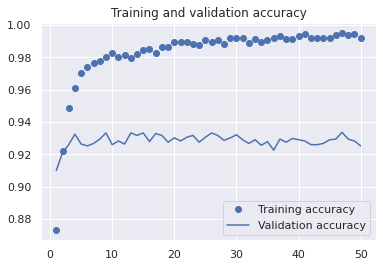

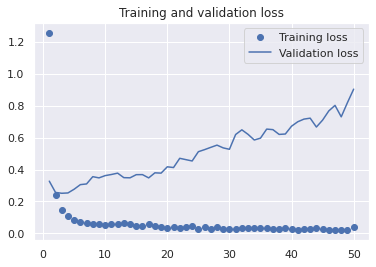

In [ ]:
acc = hist2.history['acc']
val_acc = hist2.history['val_acc']
loss = hist2.history['loss']
val_loss = hist2.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

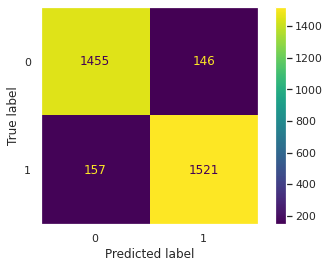

              precision    recall  f1-score   support

         0.0       0.90      0.91      0.91      1601
         1.0       0.91      0.91      0.91      1678

    accuracy                           0.91      3279
   macro avg       0.91      0.91      0.91      3279
weighted avg       0.91      0.91      0.91      3279



In [ ]:
from sklearn.metrics import plot_confusion_matrix

x_valid = features_dataVal

y_pred = model.predict(x_valid)
y_pred = np.where(y_pred < 0.5, 0, 1)

cm_fully = confusion_matrix(y_validvgg, y_pred)
dispfully = ConfusionMatrixDisplay(confusion_matrix=cm_fully,
                         display_labels=[0,1])
dispfully.plot()

plt.grid(False)
plt.show()
cl_reportfully = classification_report(y_validvgg,y_pred)

print(cl_reportfully)

In [ ]:
bag_metadata["vggfully"] = {"model": model, "conv": conv, "metrics":[cm_fully,cl_reportfully], "data":(features_dataVal,y_validvgg)} 

Visualize predictions

In [ ]:
import random
test_dir = "/content/drive/MyDrive/foodtask/ImagesTest/"

def visualize_predictions(classifier, n_cases, conv):
    print(f'Classifier : {classifier}, and CONV : {conv}')
    for i in range(0,n_cases):
        path = test_dir
        classe = (0 if i < 3 else 1)
        path = test_dir + str(classe) + "/" + str(i) + ".jpg"
        # Get picture
        img_path = path # os.path.join(path, random_img)
        prediction,_,_,img_tensor = make_prediction(classifier, img_path, conv, None)

        print("prediction : ", prediction)
        # img_tensor /= 255
        # Show picture
        plt.figure()
        plt.grid(False)
        plt.imshow(img_tensor)
        plt.show()

        if prediction < 0.5:
            print('Not Food')
        else:
            print('Food!')

Classifier : <keras.engine.sequential.Sequential object at 0x7f2044fdae50>, and CONV : <keras.engine.functional.Functional object at 0x7f204508fa10>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


prediction :  [[6.6945836e-07]]


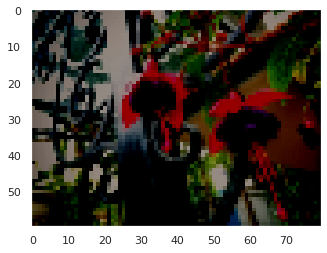

Not Food


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


prediction :  [[2.880809e-15]]


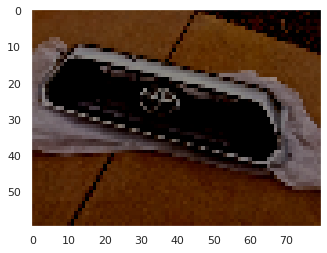

Not Food


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


prediction :  [[1.486061e-05]]


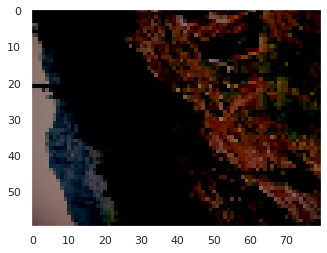

Not Food


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


prediction :  [[1.]]


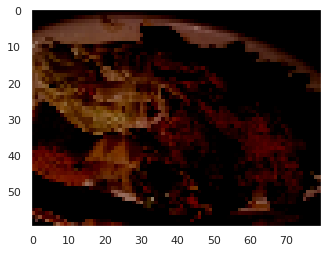

Food!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


prediction :  [[0.9999908]]


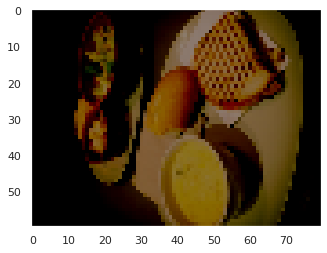

Food!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


prediction :  [[0.9999994]]


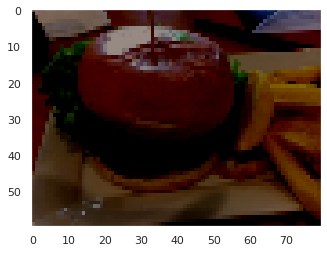

Food!


In [ ]:
visualize_predictions(model, 6,conv)

# 3rd approach : VGG16 + SVM on top

In [ ]:
model = tensorflow.keras.models.load_model("/content/drive/MyDrive/foodtask/vgg16/trained_vgg16.h5")

In [ ]:
model.summary()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


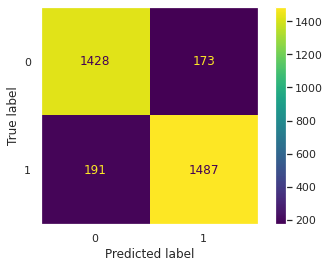

              precision    recall  f1-score   support

         0.0       0.88      0.89      0.89      1601
         1.0       0.90      0.89      0.89      1678

    accuracy                           0.89      3279
   macro avg       0.89      0.89      0.89      3279
weighted avg       0.89      0.89      0.89      3279



In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier

data_train = features_dataTrain.reshape((-1,1024))
data_valid = features_dataVal.reshape((-1,1024))
# Linear classifiers (SVM, logistic regression, etc.) with SGD training.
clf = SGDClassifier(alpha=0.001, penalty='l2', loss='hinge', random_state=42)
clf.fit(data_train, y_trainvgg)

y_pred = clf.predict(data_valid)

cm_sgd = confusion_matrix(y_validvgg, y_pred)
dispfully = ConfusionMatrixDisplay(confusion_matrix=cm_sgd,
                         display_labels=[0,1])
dispfully.plot()
plt.grid(False)
plt.show()
cl_reportsgd = classification_report(y_validvgg,y_pred)

print(cl_reportsgd)

In [ ]:
bag_metadata["vggsvm"] = {"model": clf, "conv": conv, "metrics":[cm_sgd,cl_reportsgd], "data":(features_dataVal,y_validvgg)} 

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example u

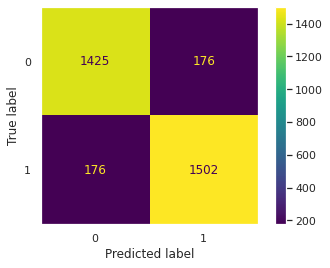

              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89      1601
         1.0       0.90      0.90      0.90      1678

    accuracy                           0.89      3279
   macro avg       0.89      0.89      0.89      3279
weighted avg       0.89      0.89      0.89      3279



In [ ]:
# Probability calibration with isotonic regression or logistic regression
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(data_train, y_trainvgg)

y_pred = sig_clf.predict(data_valid)

cm_sig = confusion_matrix(y_validvgg, y_pred)
dispfully = ConfusionMatrixDisplay(confusion_matrix=cm_sig,
                         display_labels=[0,1])
dispfully.plot()
plt.grid(False)
plt.show()
cl_reportsig = classification_report(y_validvgg,y_pred)

print(cl_reportsig)

In [ ]:
# bag_metadata["vggsvm"] = {"model": model, "conv": conv, "metrics":[cm_sig,cl_reportsig], "data":(features_dataVal,y_validvgg)} 

Visualize predictions

In [ ]:
# visualize_predictions(clf, 6,conv)

# Visualize GRAD-CAM for the VGG16 pre trained model

In [ ]:
# conv.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

prediction :  Food [1.]
prediction :  Food [1.]
prediction :  Not food [0.]


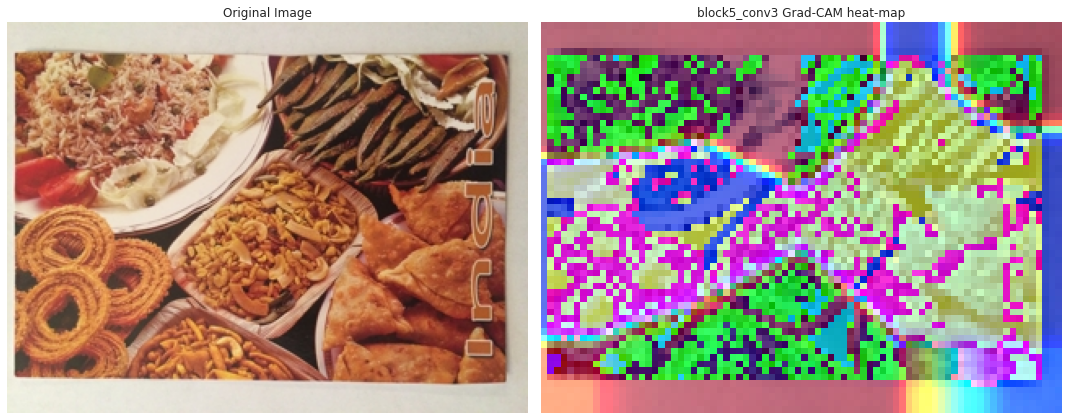

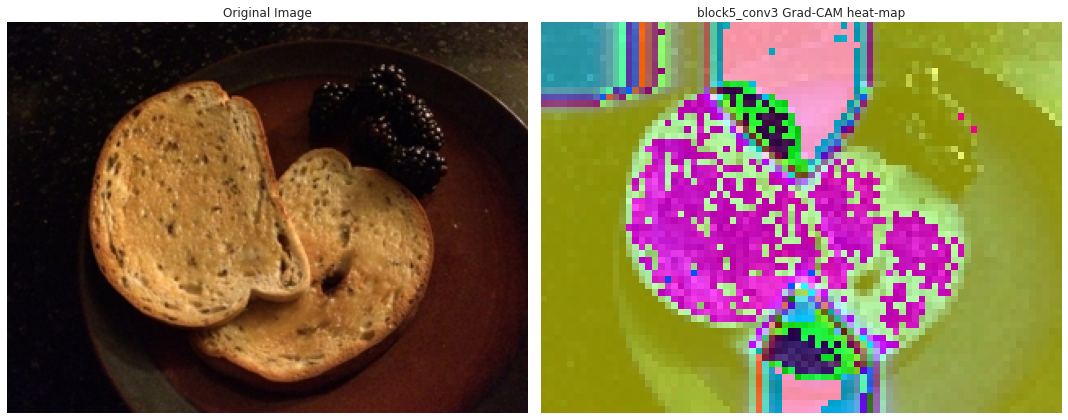

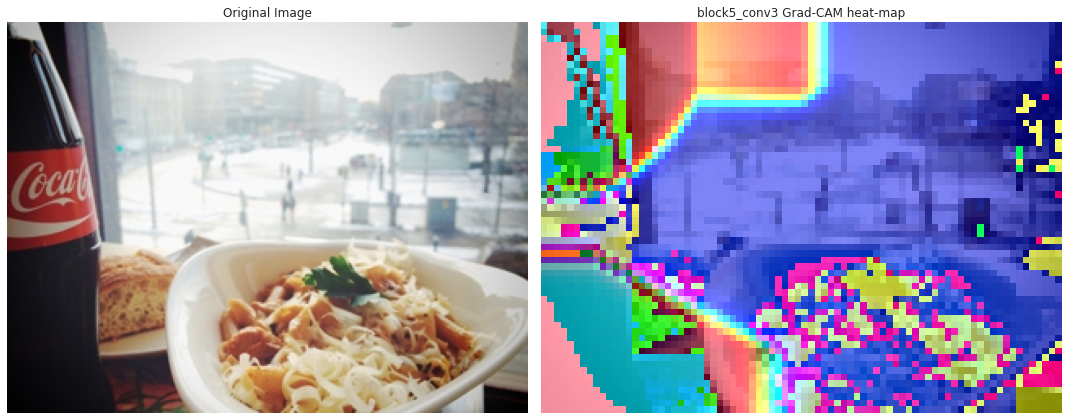

In [ ]:
from gradcam import GradCam, superimpose, sigmoid, get_img_array

model = conv

conv2D_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and isinstance(layer, tensorflow.keras.layers.Conv2D)]
activation_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and layer.__class__.__name__ == 'ReLU']
all_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and (layer.__class__.__name__ == 'ReLU' or isinstance(layer, tensorflow.keras.layers.Conv2D))]


for i in range(3):
  img_path = "/content/drive/MyDrive/foodtask/ImagesTest/1/" + str(i) + ".jpg"
  img_size = (60,80)
  last_conv_layer_name = "block5_conv3"

  ig = cv2.imread(img_path)
  ig = cv2.resize(ig, (80,60))

  img_array = asarray(ig)
  img_array = preprocess_input(img_array)

  img = img_array
  img = np.expand_dims(img,0)

  layer_name = last_conv_layer_name

  grad_cam=GradCam(conv,img,layer_name)
  if i == 1:
    grad_cam_superimposed = superimpose(img_array.reshape((60,80,3)), grad_cam, 0.5, emphasize=True)
    grad_cam_superimposed_vgg = grad_cam_superimposed
  else:
    grad_cam_superimposed = superimpose(img_array.reshape((60,80,3)), grad_cam, 0.5, emphasize=True)


  prediction,classe_x,pred, _ = make_prediction(clf, img_path, conv, None)

  img = cv2.imread(img_path)

  plt.figure(figsize=(15, 15))
  ax = plt.subplot(1, 2, 1)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.title('Original Image')

  ax = plt.subplot(1, 2, 2)
  plt.imshow(grad_cam_superimposed)
  plt.axis('off')
  plt.title(f'{last_conv_layer_name} Grad-CAM heat-map')
  plt.tight_layout()
  print("prediction : ", ("Not food" if prediction < 0.5 else "Food"), prediction)


grad-cam for all conv layers in the model

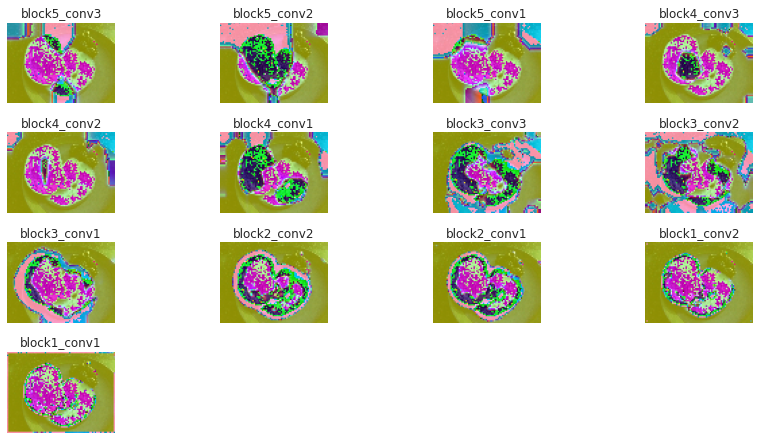

In [ ]:
img_path = "/content/drive/MyDrive/foodtask/ImagesTest/1/1.jpg"
img_size = (60,80)
last_conv_layer_name = "block5_conv3"

ig = cv2.imread(img_path)
ig = cv2.resize(ig, (80,60))

img_array = asarray(ig)
img_array = preprocess_input(img_array)
img = np.expand_dims(img_array,0)

plt.figure(figsize=(12, 20))
for i, layer in enumerate(conv2D_layers):
  grad_cam=GradCam(model,img,layer)
  grad_cam_emphasized = superimpose(img_array.reshape((60,80,3)), grad_cam, 0.5, emphasize=True)
  ax = plt.subplot(13, 4, i +1)
  plt.imshow(grad_cam_emphasized)
  plt.title(layer)
  plt.axis("off")
plt.tight_layout()

In [ ]:
datatr = data["Train/"]
datate = data["Valid/"]

(trainX, valX, trainY, valY) = train_test_split(np.array(datatr), y_train,
	test_size=0.25, random_state=42)

trainX = trainX.reshape((len(trainX), h,w, 1))
valX = valX.reshape((len(valX), h,w, 1))
print(type(trainX), type(trainY))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


# Keras own architecture CNN

In [ ]:
# UNZIP AND GET MODELs
!unzip "/content/drive/MyDrive/foodtask/OwnArchCNN.zip" -d /content/model
# model = tensorflow.keras.models.load_model("/content/trained_vgg16 (1).h5")

Archive:  /content/drive/MyDrive/foodtask/OwnArchCNN.zip
   creating: /content/model/Model1/
   creating: /content/model/Model1/assets/
  inflating: /content/model/Model1/keras_metadata.pb  
  inflating: /content/model/Model1/saved_model.pb  
   creating: /content/model/Model1/variables/
  inflating: /content/model/Model1/variables/variables.data-00000-of-00001  
  inflating: /content/model/Model1/variables/variables.index  
   creating: /content/model/Valid/
   creating: /content/model/Valid/0/
  inflating: /content/model/Valid/0/0.jpg  
  inflating: /content/model/Valid/0/1.jpg  
  inflating: /content/model/Valid/0/2.jpg  
  inflating: /content/model/Valid/0/3.jpg  
  inflating: /content/model/Valid/0/4.jpg  
  inflating: /content/model/Valid/0/5.jpg  
   creating: /content/model/Valid/1/
  inflating: /content/model/Valid/1/0.jpg  
  inflating: /content/model/Valid/1/1.jpg  
  inflating: /content/model/Valid/1/2.jpg  
  inflating: /content/model/Valid/1/3.jpg  
  inflating: /content/

In [ ]:
model = tensorflow.keras.models.load_model("/content/model/Model1")

In [ ]:
# aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
# 	width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
# 	horizontal_flip=True, fill_mode="nearest")
def getmodel(h,w):

  model = Sequential()

  model.add(Conv2D(16, (3,3), padding = "same", activation = "relu", input_shape = (h,w,1)))
  model.add(Conv2D(16, (3,3), padding = "same", activation = "relu"))
  model.add(BatchNormalization(axis = -1))

  model.add(Conv2D(32, (3,3), padding = "same", activation = "relu"))
  model.add(BatchNormalization(axis = -1))
  model.add(Conv2D(32, (3,3), padding = "same", activation = "relu"))
  model.add(BatchNormalization(axis = -1))

  model.add(Conv2D(128, (3,3), padding = "same", activation = "relu"))
  model.add(BatchNormalization(axis = -1))
  model.add(Conv2D(128, (3,3), padding = "same", activation = "relu"))
  model.add(BatchNormalization(axis = -1))

  model.add(Flatten())
  model.add(Dense(32))

  model.add(BatchNormalization())
  model.add(Dense(1, activation = 'sigmoid'))

  return model

def trainmodel(model,alldata,aug,epochs):
  trainX, trainY = alldata[0], alldata[1]
  valX, valY = alldata[2], alldata[3]
  # xtest, ytest = alldata[4], alldata[5]
  
  opt = Adam()
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

  checkpoint_path = "content/food/cp.ckpt"
  checkpoint_dir = os.path.dirname(checkpoint_path)

  # Create a callback that saves the model's weights
  cp = tensorflow.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                  save_weights_only=True,
                                                  verbose=1)
  # snippet of using the ReduceLROnPlateau callback and # simple early stopping

  rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=150)
  history = model.fit(x = aug.flow(trainX, trainY, batch_size=256),
                      validation_data = (valX,valY), epochs=epochs, 
                      batch_size=256, callbacks=[rlrop,cp])
  model.save('/content/food/second')
  _, accuracy = model.evaluate(valX, valY)

  return accuracy

# evaluate the keras model
aug = ImageDataGenerator()
alldata = [trainX,trainY,valX,valY]
epochs = 25
# model = getmodel(h,w)
# acc = trainmodel(model, alldata,aug,epochs)

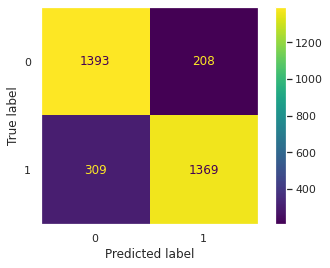

              precision    recall  f1-score   support

         0.0       0.82      0.87      0.84      1601
         1.0       0.87      0.82      0.84      1678

    accuracy                           0.84      3279
   macro avg       0.84      0.84      0.84      3279
weighted avg       0.84      0.84      0.84      3279



In [ ]:
x_valid = np.array(datate)
x_valid = x_valid.reshape((len(x_valid), h,w, 1))

y_pred = model.predict(x_valid)
y_pred = np.where(y_pred < 0.5, 0, 1)

cm_own = confusion_matrix(y_valid, y_pred)
dispfully = ConfusionMatrixDisplay(confusion_matrix=cm_own,
                         display_labels=[0,1])
dispfully.plot()
plt.grid(False)
plt.show()
cl_reportOwn = classification_report(y_valid,y_pred)

print(cl_reportOwn)

In [ ]:
bag_metadata["Own"] = {"model": model, "conv": None, "metrics":[cm_own,cl_reportOwn], "data":(x_valid,y_valid)} 

In [ ]:
bag_metadata.keys()

dict_keys(['DNN', 'vggfully', 'vggsvm', 'Own'])

# Visualize GRAD-CAM

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 60, 80, 16)        160       
                                                                 
 conv2d_13 (Conv2D)          (None, 60, 80, 16)        2320      
                                                                 
 batch_normalization_12 (Bat  (None, 60, 80, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_14 (Conv2D)          (None, 60, 80, 32)        4640      
                                                                 
 batch_normalization_13 (Bat  (None, 60, 80, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_15 (Conv2D)          (None, 60, 80, 32)       

prediction :  Not food [[0.3465631]]
prediction :  Food [[0.9901761]]
prediction :  Not food [[0.10886151]]


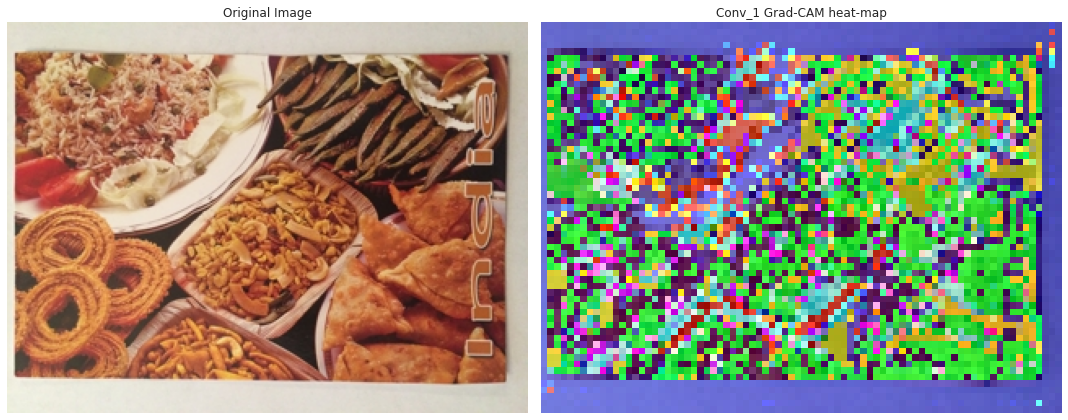

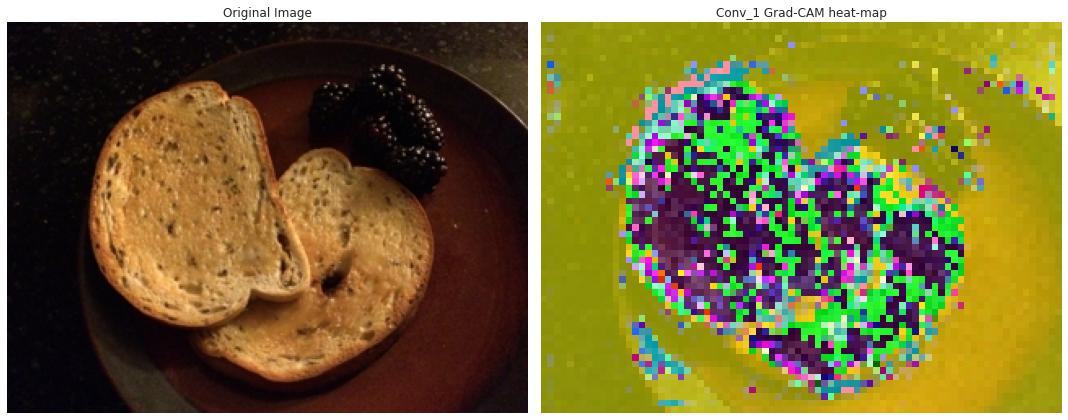

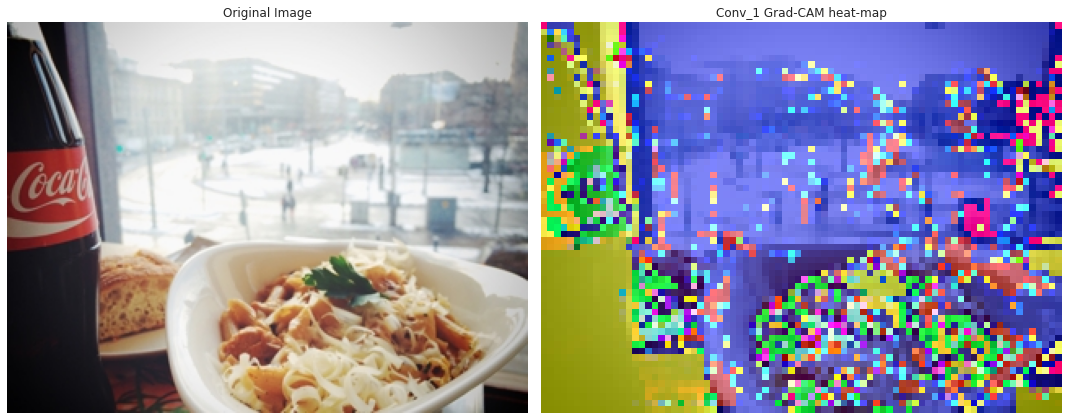

In [ ]:
conv2D_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and isinstance(layer, tensorflow.keras.layers.Conv2D)]
activation_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and layer.__class__.__name__ == 'ReLU']
all_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and (layer.__class__.__name__ == 'ReLU' or isinstance(layer, tensorflow.keras.layers.Conv2D))]

w = 80
h = 60

for i in range(3):
  img_path = "/content/drive/MyDrive/foodtask/ImagesTest/1/" + str(i) + ".jpg"
  img_size = (60,80)

  last_conv_layer_name = "conv2d_17"

  ig = cv2.imread(img_path)
  #### For grayscale own architecture:
  gs_image = cv2.cvtColor(ig, cv2.COLOR_BGR2GRAY)
  gs_image = cv2.resize(gs_image,(80,60))
  gs_image = gs_image.reshape((1,h,w,1))
  img_array_gs = asarray(gs_image) 
  img = img_array_gs

  img_array = preprocess_input(get_img_array(img_path, size=img_size))
  layer_name = last_conv_layer_name

  grad_cam=GradCam(model,img,layer_name)
  if i == 1:
    grad_cam_superimposed = superimpose(img_array.reshape((60,80,3)), grad_cam, 0.5, emphasize=True)
    grad_cam_superimposed_own = grad_cam_superimposed
  else:
    grad_cam_superimposed = superimpose(img_array.reshape((60,80,3)), grad_cam, 0.5, emphasize=True)

  prediction,classe_x,pred, _ = make_prediction(model, img_path, None, None)

  img = cv2.imread(img_path)
  plt.figure(figsize=(15, 15))
  ax = plt.subplot(1, 2, 1)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.title('Original Image')

  ax = plt.subplot(1, 2, 2)
  plt.imshow(grad_cam_superimposed)
  plt.axis('off')
  plt.title('Conv_1 Grad-CAM heat-map')
  plt.tight_layout()
  print("prediction : ", ("Not food" if prediction < 0.5 else "Food"), prediction)


Visualize grad-cam for multiple conv layers

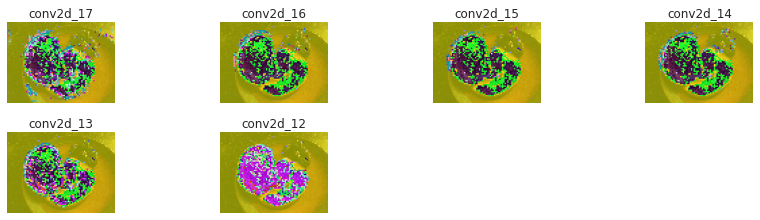

In [ ]:
img_path = "/content/drive/MyDrive/foodtask/ImagesTest/1/1.jpg"
img_size = (60,80)

last_conv_layer_name = "conv2d_17"

ig = cv2.imread(img_path)
#### For grayscale own architecture:
gs_image = cv2.cvtColor(ig, cv2.COLOR_BGR2GRAY)
gs_image = cv2.resize(gs_image,(80,60))
gs_image = gs_image.reshape((1,h,w,1))
img_array_gs = asarray(gs_image)

img = img_array_gs
img_array = preprocess_input(get_img_array(img_path, size=img_size))
plt.figure(figsize=(12, 20))
for i, layer in enumerate(conv2D_layers):
  grad_cam=GradCam(model,img,layer)
  grad_cam_emphasized = superimpose(img_array.reshape((60,80,3)), grad_cam, 0.5, emphasize=True)
  ax = plt.subplot(13, 4, i +1)
  plt.imshow(grad_cam_emphasized)
  plt.title(layer)
  plt.axis("off")
plt.tight_layout()

Interestingly, we can see that the first conv layer **conv2d_17** has a more defined gradient output (a more homogenous gradient of color) whereas the subsequents layers, seem to learn other patterns beyond the food shape (we can see some activation importance coming from the plate as well!!)

# All confusion matrix

<Figure size 864x1440 with 0 Axes>

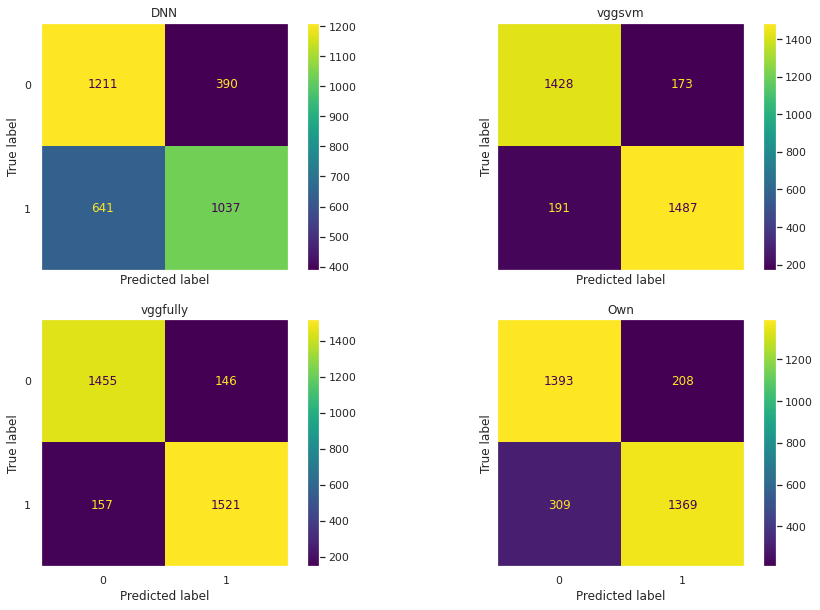

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plt.figure(figsize=(12, 20))
# plt.grid(False)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10),sharex=True, sharey=True)
j = 0
for i,key in enumerate(bag_metadata.keys()):

  cm = bag_metadata[key]["metrics"][0]
  dispfully = ConfusionMatrixDisplay(confusion_matrix=cm,
                         display_labels=[0,1])
  if i == 2: 
    j +=1
    i -= 2
  elif i == 3:
    i -=2

  disp = dispfully.plot(
                 cmap='viridis', ax=axes[i][j])
  axes[i][j].set_title(key)
  axes[i][j].grid(False)
  plt.title(key)

# plt.tight_layout()

# Comparison for the 2 CNN models

prediction :  Not food [[0.10886151]]


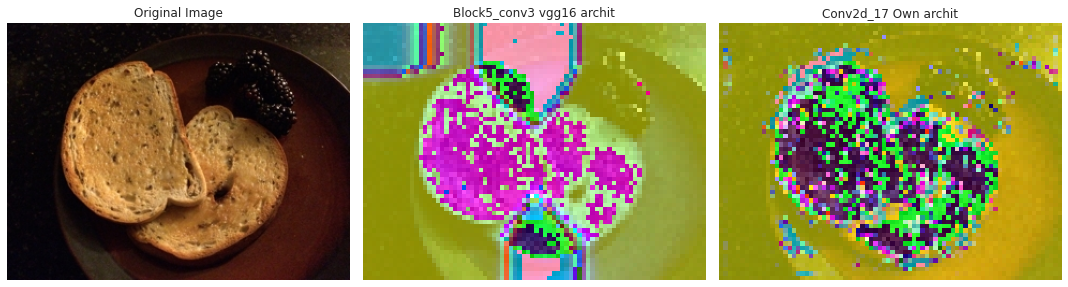

In [ ]:
img_path = "/content/drive/MyDrive/foodtask/ImagesTest/1/1.jpg"
img_size = (60,80)

img = cv2.imread(img_path)
plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 3, 2)
plt.imshow(grad_cam_superimposed_vgg)
plt.axis('off')
plt.title(f'Block5_conv3 vgg16 archit')

ax = plt.subplot(1, 3, 3)
plt.imshow(grad_cam_superimposed_own)
plt.axis('off')
plt.title(f'Conv2d_17 Own archit')

plt.tight_layout()
print("prediction : ", ("Not food" if prediction < 0.5 else "Food"), prediction)

# New CNN attempts


Due to time and computational process constraints, I'll build several new cnn model with only 20 epochs, changing some parameters like:

* kernel_initializer ("glorot_uniform" **or** "he_normal")
* kernel_regularizer (l2(0.0001 **or** None)
* kernel_size **
* dropouts (3 layers **or** 1 layer **or** None) 
* data augmentation. (True **or** None)


** the kernel_size: 

Borrowing the concept of human learning from baby to adult when decyphering an image and adapting for this task, I will try some different patterns through the layers of the model, stablishing 3 parts of "learning":
1.  baby: where we first have a broad picture of an image without any categorization of shapes and colors (bigger kernel sizes e.g. 5 or 7)
2.  child: where we can define and characterize lines, countours and colors (small kernel sizes e.g. 3, or 1)
3.  adult: where we can generalize without looking to specific parts but rather to the whole context and are able to infer concepts, ideas and categorizations (bigger kernel sizes e.g. 5 or 7)


Below you can find the trained models and their parameters.

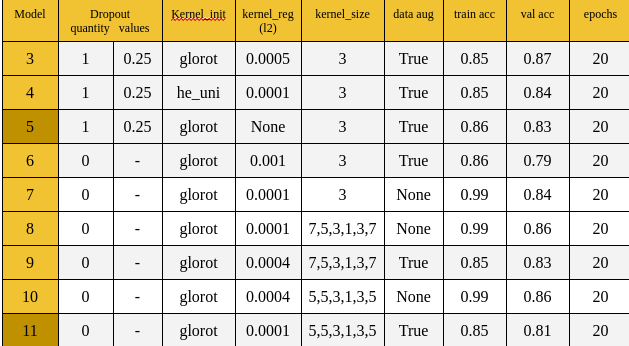

Lets now check some graphs for the *val_loss* and *val_accuracy* for these round of trained models.

In [ ]:
dir = "/content/drive/MyDrive/foodtask/histories/"

import plotly.graph_objects as go
y = np.arange(1,20,1)
colors = ["red", "green", "black", "gray", "yellow", "orange", "purple", "brown","blue"]
plt.figure(figsize=(15,15))
i = 0
fig = go.Figure()
for each in os.listdir(dir):

  if "Dict" in each:
    filer = "/content/drive/MyDrive/foodtask/histories/" + str(each)
    hist = pickle.load(open(filer,"rb"))

    if len(each) == 18:
      mod_n = each[-2:]
    else:
      mod_n = each[-1]
    # fig.add_trace(go.Scatter(x=y, y=np.array(hist["val_accuracy"]), name = ("val acc model " + mod_n), line = dict(color = colors[i])))
    fig.add_trace(go.Scatter(x=y, y=np.array(hist["accuracy"]), name = ("train acc model " + mod_n), line = dict(color = colors[i], dash = 'dash') ))
    i+= 1

fig.show()


<Figure size 1080x1080 with 0 Axes>

If you can visalize the ITERATIVE Plotly graph, check the static one below

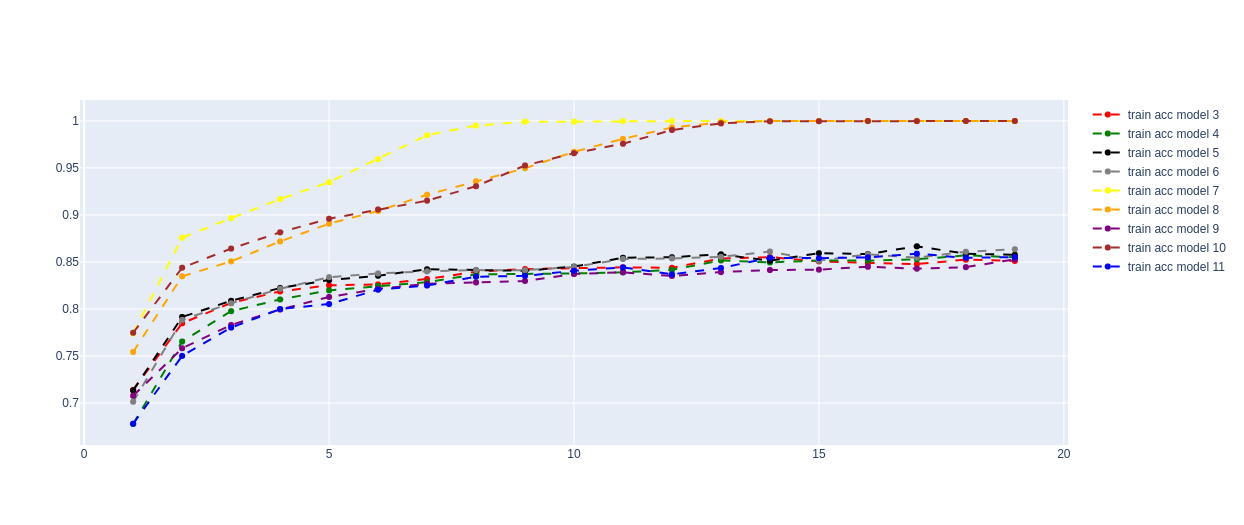

For models 5 and 11

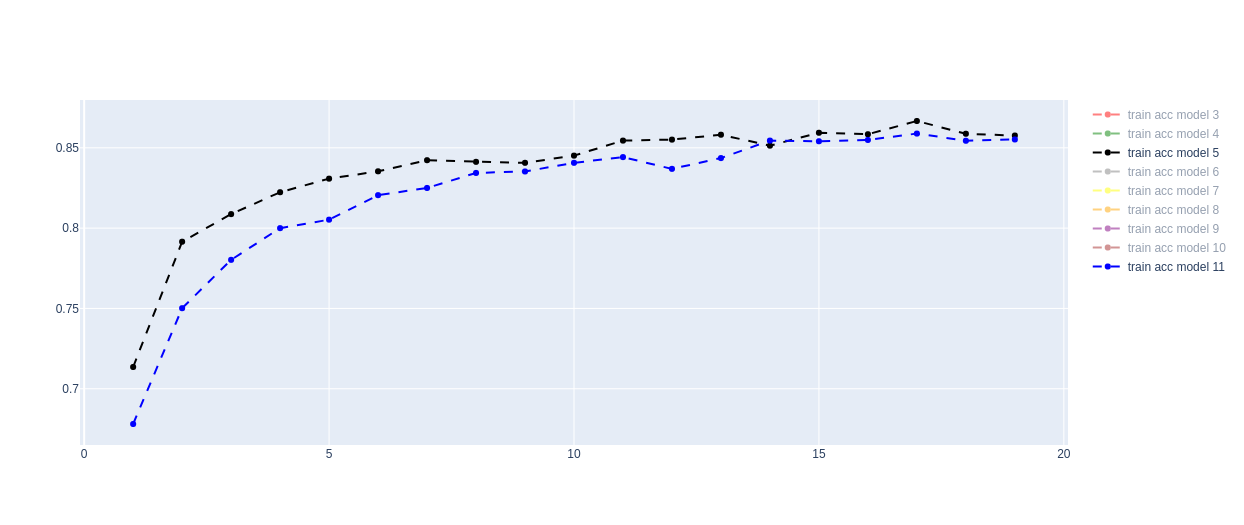

From these first round of attempts, a final CNN version (called **own2**) will be trained with more layers added and 50 epochs training with data augmentation.

Although the choosing of the model doesn't follow any strict criterium, I'll give priority to data augmentation and to not overfitting. 

Furthermore, as the models were simple and trained with only 20 epochs, 
I don't think that they would have a great performance difference between them WHEN training with more epochs in a higher complex architecture. 

Neverthelles, respecting the above criterium, models 5 and 11 are chosen and a blend of their parameters will be made. 


* kernel size: will follow the same pattern as the model5  (also the same as *VGG16* one (**3** for all layers)).
* dropouts: the same as model11 (**None**)
* kernel reg : **None**
* data aug: **True**

I added now 8 more layers (4 conv2d and 4 batch_normalization) and boosted up the final **dense** layer's node (from 32 to 128)


Final accuracies:

tr acc : 0.89

val acc : 0.75 


In [ ]:
from tensorflow.keras.regularizers import l2
datatr = data["Train/"]
datate = data["Valid/"]

(trainX, valX, trainY, valY) = train_test_split(np.array(datatr), y_train,
	test_size=0.25, random_state=42)

trainX = trainX.reshape((len(trainX), h,w, 1))
valX = valX.reshape((len(valX), h,w, 1))
print(type(trainX), type(trainY))

aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
	width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
	horizontal_flip=True, fill_mode="nearest")

aug_val = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
	width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
	horizontal_flip=True, fill_mode="nearest")

def getmodel2(h,w, reg, init):

  model = Sequential()

  model.add(Conv2D(16, (3,3), padding = "same", activation = "relu", input_shape = (h,w,1), kernel_regularizer = reg))
  model.add(Conv2D(16, (3,3), padding = "same", activation = "relu", kernel_regularizer = reg, kernel_initializer = init))
  model.add(BatchNormalization(axis = -1))

  model.add(Conv2D(32, (3,3), padding = "same", activation = "relu", kernel_regularizer = reg, kernel_initializer = init))
  model.add(BatchNormalization(axis = -1))
  model.add(Conv2D(32, (3,3), padding = "same", activation = "relu", kernel_regularizer = reg, kernel_initializer = init))
  model.add(BatchNormalization(axis = -1))
  # model.add(Dropout(0.25))
  model.add(Conv2D(64, (3,3), padding = "same", activation = "relu", kernel_regularizer = reg, kernel_initializer = init))
  model.add(BatchNormalization(axis = -1))
  model.add(Conv2D(64, (3,3), padding = "same", activation = "relu", kernel_regularizer = reg, kernel_initializer = init))
  model.add(BatchNormalization(axis = -1))

  model.add(Conv2D(128, (3,3), padding = "same", activation = "relu", kernel_regularizer = reg, kernel_initializer = init))
  model.add(BatchNormalization(axis = -1))
  model.add(Conv2D(128, (3,3), padding = "same", activation = "relu", kernel_regularizer = reg, kernel_initializer = init))
  model.add(BatchNormalization(axis = -1))
  # model.add(Dropout(0.25))
  model.add(Conv2D(128, (3,3), padding = "same", activation = "relu", kernel_regularizer = reg, kernel_initializer = init))
  model.add(BatchNormalization(axis = -1))
  model.add(Conv2D(128, (3,3), padding = "same", activation = "relu", kernel_regularizer = reg, kernel_initializer = init))
  model.add(BatchNormalization(axis = -1))

  model.add(Flatten())
  model.add(Dense(128))

  model.add(BatchNormalization())
  # model.add(Dropout(0.5))
  model.add(Dense(1, activation = 'sigmoid'))

  return model

def trainmodel2(model,alldata,aug,aug_val,epochs):
  trainX, trainY = alldata[0], alldata[1]
  valX, valY = alldata[2], alldata[3]
  
  opt = Adam()
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

  checkpoint_path = "content/food/cp.ckpt"
  checkpoint_dir = os.path.dirname(checkpoint_path)
  history = model.fit(x = aug.flow(trainX, trainY, batch_size=256),
                      validation_data = aug_val.flow(valX,valY,batch_size=256), epochs=epochs, 
                      batch_size=256)
  model.save('/content/food/cnn5')
  
  with open('trainHistoryDict15', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
  
  _, accuracy = model.evaluate(valX, valY)

  return accuracy

# evaluate the keras model
# aug = ImageDataGenerator()
alldata = [trainX,trainY,valX,valY]
epochs = 50
# reg = l2(0.0001)
reg = None
init = "glorot_uniform"
# model = getmodel2(h,w,reg,init)
# acc = trainmodel2(model, alldata,aug,aug_val,epochs)

In [ ]:
import plotly.graph_objects as go
y = np.arange(1,50,1)
colors = ["red", "green", "black", "gray", "yellow", "orange", "purple", "brown","blue"]
plt.figure(figsize=(15,15))

fig = go.Figure()

filer = "/content/drive/MyDrive/foodtask/histories/trainHistoryDict15"
hist = pickle.load(open(filer,"rb"))


mod_n = 15

fig.add_trace(go.Scatter(x=y, y=np.array(hist["val_accuracy"]), name = ("val acc model own2"), line = dict(color = colors[1], dash = 'dot')))
fig.add_trace(go.Scatter(x=y, y=np.array(hist["accuracy"]), name = ("train acc model own2"), line = dict(color = colors[0], dash = 'dash') ))
# plt.ylim([0,1])
fig.add_trace(go.Scatter(x=y, y=np.array(hist["val_loss"]), name = ("val loss model own2"), line = dict(color = colors[5], dash = 'dot')))
fig.add_trace(go.Scatter(x=y, y=np.array(hist["loss"]), name = ("train loss model own2"), line = dict(color = colors[2], dash = 'dash') ))
fig.update_yaxes(range=[0,1])

<Figure size 1080x1080 with 0 Axes>

If you can visalize the ITERATIVE Plotly graph, check the static one below

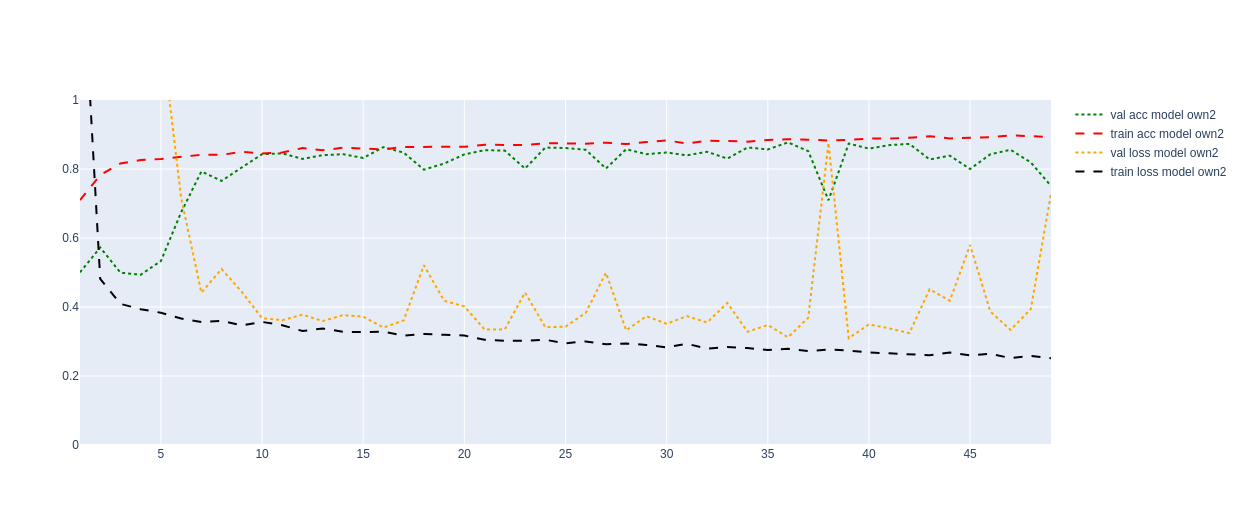

In [ ]:
!unzip "/content/drive/MyDrive/foodtask/cnn5.zip" -d /content/cnn


In [ ]:
modelown2 = tensorflow.keras.models.load_model("/content/cnn")

In [ ]:
modelown2.summary()

prediction :  Food [[0.6117783]]
prediction :  Food [[0.9781345]]
prediction :  Not food [[0.00065145]]


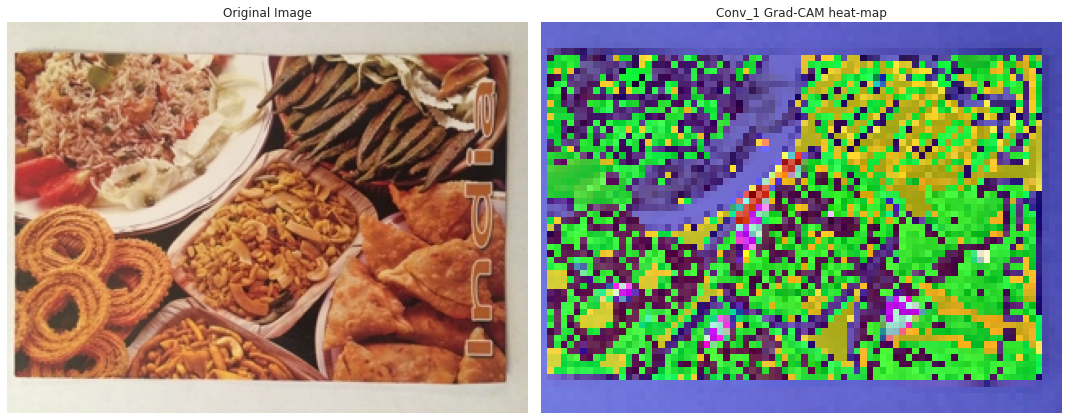

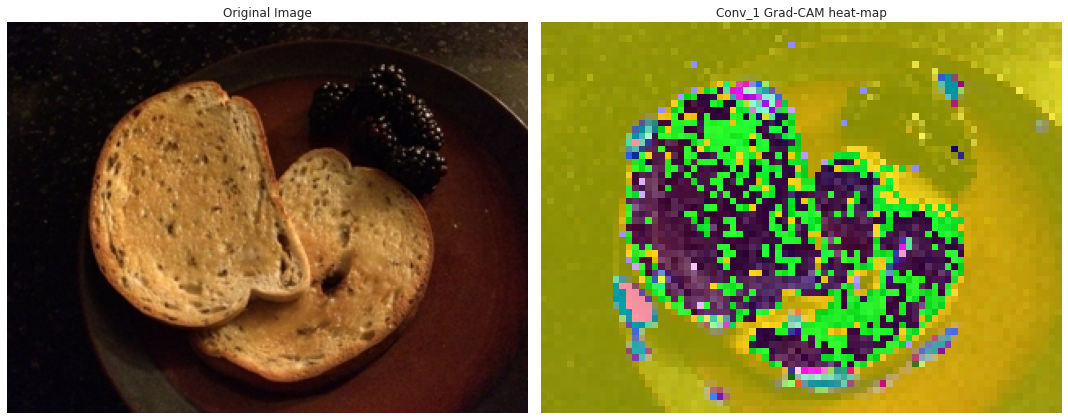

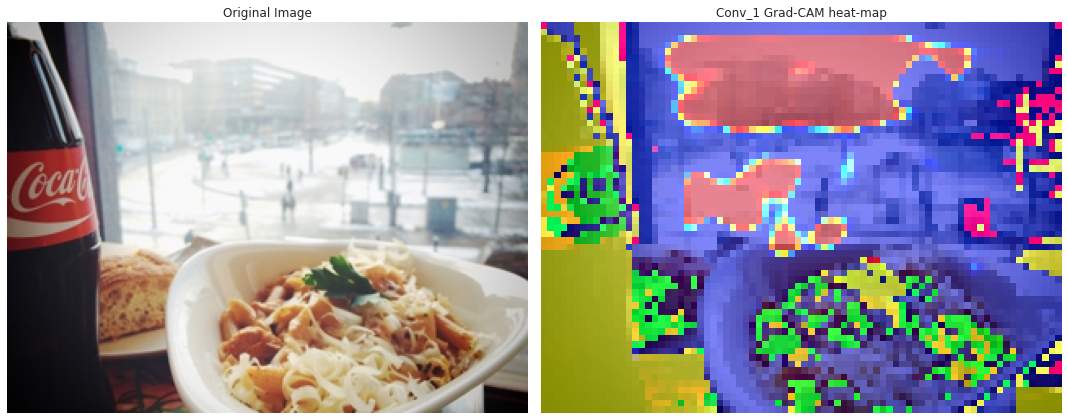

In [ ]:
model = modelown2

for i in range(3):
  img_path = "/content/drive/MyDrive/foodtask/ImagesTest/1/" + str(i) + ".jpg"
  img_size = (60,80)

  last_conv_layer_name = "conv2d_41"

  ig = cv2.imread(img_path)
  #### For grayscale own architecture:
  gs_image = cv2.cvtColor(ig, cv2.COLOR_BGR2GRAY)
  gs_image = cv2.resize(gs_image,(80,60))
  gs_image = gs_image.reshape((1,h,w,1))
  img_array_gs = asarray(gs_image) 
  img = img_array_gs

  img_array = preprocess_input(get_img_array(img_path, size=img_size))
  layer_name = last_conv_layer_name

  grad_cam=GradCam(model,img,layer_name)
  grad_cam_superimposed = superimpose(img_array.reshape((60,80,3)), grad_cam, 0.5, emphasize=True)

  prediction,classe_x,pred, _ = make_prediction(model, img_path, None, None)

  img = cv2.imread(img_path)
  plt.figure(figsize=(15, 15))
  ax = plt.subplot(1, 2, 1)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.title('Original Image')

  ax = plt.subplot(1, 2, 2)
  plt.imshow(grad_cam_superimposed)
  plt.axis('off')
  plt.title('Conv_1 Grad-CAM heat-map')
  plt.tight_layout()
  print("prediction : ", ("Not food" if prediction < 0.5 else "Food"), prediction)


# Comparing all CNN models with one image

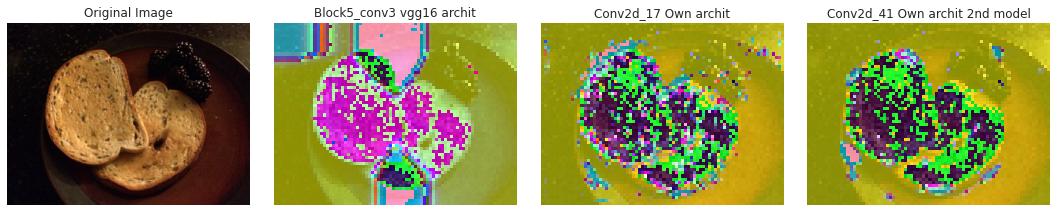

In [ ]:

from gradcam import *

img_path = "/content/drive/MyDrive/foodtask/ImagesTest/1/1.jpg"
img_size = (60,80)

img = cv2.imread(img_path)
plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 4, 2)
plt.imshow(grad_cam_superimposed_vgg)
plt.axis('off')
plt.title(f'Block5_conv3 vgg16 archit')

ax = plt.subplot(1, 4, 3)
plt.imshow(grad_cam_superimposed_own)
plt.axis('off')
plt.title(f'Conv2d_17 Own archit')

ax = plt.subplot(1, 4, 4)
plt.imshow(grad_cam_superimposed_own2)
plt.axis('off')
plt.title(f'Conv2d_41 Own archit 2nd model')

plt.tight_layout()


# BONUS: Bootstrap sampling with Decision Tree Classifier

What if we could drastically reduce the input variables and still have a reasonable model to predict?


While DNN are so commonly used when task is to detect and classify images, some other approaches exist and sometimes are worth checking!


For the sake of curiosity, let's try a bootstrap sampling with 5 samples, only 150 input variables (PCA) and half the training data!

As we are going to train a Decision Tree Classifier, we'll be using the *data_stack* data, as image is unrolled in one dimension.

In [ ]:
data_stack["Train/"].shape

(13113, 4801)

Reducing the dimension using PCA. 

Let's check how much of information we conserve using 150 variables (a drastic change of 97% of leave out)

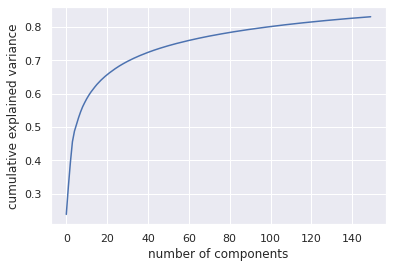

In [ ]:
from sklearn.decomposition import PCA
import numpy as np


pca = PCA(150)
pca.fit(data_stack["Train/"][:,:-1])

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');


With 150 components, our data conserve around 81% of the information!

Now, we transform our original data so to take only these 150 components:

In [ ]:
##### New and transformed DATA:
xtrain = data_stack["Train/"][:,:-1]
comp = pca.transform(xtrain)
comp.shape

(13113, 150)

In [ ]:
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
import time
import random


iter = 5 #### design sampling
stats = []

x = np.concatenate((xtrain,y_train),axis=1)

## the size of our training:
n_size = int(0.5*len(x))

st = time.time()

for _ in range(iter):

  dat = resample(x,n_samples=n_size)
  (trainx, valx, trainy, valy) = train_test_split(dat[:,:-1], dat[:,-1], stratify = dat[:,-1],
	test_size=0.2, random_state=42)

  model = DecisionTreeClassifier(random_state = 1234)
  model.fit(trainx,trainy)

  pred = model.predict(valx)
  score = accuracy_score(valy,pred)
  # score
  stats.append(score)

end = time.time()
print("Time consumed : ", np.round((end - st),3))
print(f"Mean accuracy : {np.mean(stats):.3f}")
stats

Time consumed :  149.351
Mean accuracy : 0.751


[0.7416158536585366,
 0.739329268292683,
 0.7454268292682927,
 0.7644817073170732,
 0.7629573170731707]

# XAI: SHAP values

Another interesting approach to explain a ML model comes with [SHAP values](https://shap-lrjball.readthedocs.io/en/latest/).


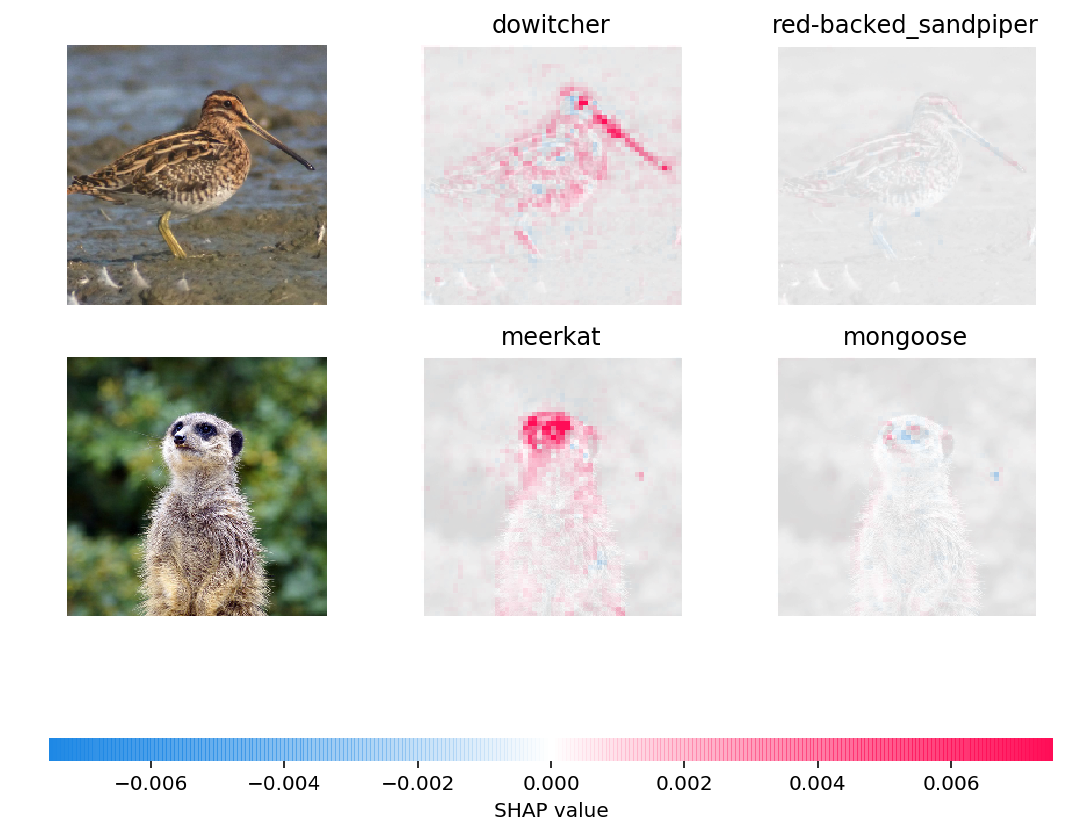





Nevertheless, due to Tensorflow version incompability, SHAP values couldn't be used here as downgrading Tensorflow would require remodeling all the code for training the models.

references:

https://shap-lrjball.readthedocs.io/en/latest/example_notebooks/deep_explainer/Front%20Page%20DeepExplainer%20MNIST%20Example.html

threads reporting the issues:

https://github.com/tensorflow/probability/issues/540

https://github.com/slundberg/shap/issues/2189

https://github.com/slundberg/shap/pull/2355